In [4]:
# Python
import itertools
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt 
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import funciones
import xgboost as xgb

In [6]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
for i in range(len(dataframes)):
  dataframes[i] = dataframes[i].reindex(pd.date_range(start=dataframes[i].index.min(), end=dataframes[i].index.max(), freq='B'))
  dataframes[i] = dataframes[i].fillna(0)
    
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

In [7]:
def extract_time_features(index):
    return pd.Series({
        'dayofweek': index.dayofweek,
        'quarter': index.quarter,
        'month': index.month,
        'year': index.year,
        'dayofyear': index.dayofyear,
        'dayofmonth': index.day,
        'weekofyear': index.isocalendar().week
    })
def add_lags(df, titulo):
    target_map = df[titulo].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # df_1['PJME_MW'].shift(1)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # df_1['PJME_MW'].shift(2)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # df_1['PJME_MW'].shift(3)
    return df
  
for i in range(len(dataframes)):
    time_features = dataframes[i].index.to_series().apply(extract_time_features)
    dataframes[i] = pd.concat([dataframes[i], time_features], axis=1)
    dataframes[i] = add_lags(dataframes[i], titulos[i])
    


In [8]:
# TRAIN TEST
n_train = 0.9
train_copa = dataframes[0].iloc[:round(len(dataframes[0])*n_train)]
test_copa = dataframes[0].iloc[round(len(dataframes[0])*n_train):]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:round(len(dataframes[1])*n_train)]
test_recursos = dataframes[1].iloc[round(len(dataframes[1])*n_train):]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:round(len(dataframes[2])*n_train)]
test_regalias = dataframes[2].iloc[round(len(dataframes[2])*n_train):]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((1584, 11)), test((176, 11))
Recursos: train((1995, 11)), test((222, 11))
Regalias: train((1985, 11)), test((221, 11))


In [ ]:
results_train_test = []
predictions_test = []
best_params = pd.read_csv("xgb_best_params.csv",sep=";")

for i, df_train in enumerate(dataframes_train):
    
    params = eval(best_params.iloc[i]["best_params"])
    
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear' , 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    TARGET = titulos[i]
    
    df_test = dataframes_test[i][TARGET]
    model = xgb.XGBRegressor(**params )
    
    X_train = dataframes_train[i][FEATURES]
    y_train = dataframes_train[i][TARGET]
    X_test= dataframes_test[i][FEATURES]
    y_test= dataframes_test[i][TARGET]
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)]
    )
    
    pred_test = model.predict(X_test)
    pred_test = pd.Series(pred_test, index=dataframes_test[i].index)
    predictions_test.append(pred_test)
    
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    mse_test = mean_squared_error(df_test, pred_test)
    mae_test = mean_absolute_error(df_test, pred_test)
    rmse = np.sqrt(mean_squared_error(df_test, pred_test))
    results_train_test.append({
        "model": model,
        "name": titulos[i],
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_test": mape_test,
        "mse_test":mse_test,
        "mape_mean": mape_mean,
        "mae_test": mae_test,
        "rmse": rmse
    })


[0]	validation_0-rmse:2271328.15021
[1]	validation_0-rmse:2244677.66807


[2]	validation_0-rmse:2211852.77311
[3]	validation_0-rmse:2193022.83293
[4]	validation_0-rmse:2175026.40825
[5]	validation_0-rmse:2152229.39783
[6]	validation_0-rmse:2126804.10534
[7]	validation_0-rmse:2113124.26716
[8]	validation_0-rmse:2098179.03128
[9]	validation_0-rmse:2083159.96629
[10]	validation_0-rmse:2067729.42316
[11]	validation_0-rmse:2051339.86261
[12]	validation_0-rmse:2040028.82204
[13]	validation_0-rmse:2029983.65719
[14]	validation_0-rmse:2021754.06597
[15]	validation_0-rmse:2018946.49655
[16]	validation_0-rmse:2013153.60996
[17]	validation_0-rmse:2000644.00124
[18]	validation_0-rmse:1990058.82570
[19]	validation_0-rmse:1987002.35159
[20]	validation_0-rmse:1982555.87441
[21]	validation_0-rmse:1971217.36474
[22]	validation_0-rmse:1963035.18611
[23]	validation_0-rmse:1957125.60073
[24]	validation_0-rmse:1955420.00308
[25]	validation_0-rmse:1946791.98187
[26]	validation_0-rmse:1946357.73315
[27]	validation_0-rmse:1940573.83002
[28]	validation_0-rmse:1934054.02662
[29]	vali

,model,name,len_train,len_test,mape_test,mse_test,mape_mean,mae_test,rmse
0,"XGBRegressor(base_score=None, booster=None, ca...",CHU_COPA_AJUST,1584,176,"696,802,963,668,707,442,688.00","696,802,963,668,707,442,688.00","758,549,686,672,395,206,656.00","1,301,328.72","2,054,213.32"
1,"XGBRegressor(base_score=None, booster=None, ca...",CHU_REC_PROPIOS_AJUST,1995,222,"390,317,608,200,093,499,392.00","390,317,608,200,093,499,392.00","584,990,421,138,727,370,752.00","918,239.48","1,215,410.70"
2,"XGBRegressor(base_score=None, booster=None, ca...",CHU_REGALIAS_AJUST,1985,221,"6,052,706,536,148,655,144,960.00","6,052,706,536,148,655,144,960.00","5,891,392,032,994,430,550,016.00","2,710,326.10","6,800,667.13"


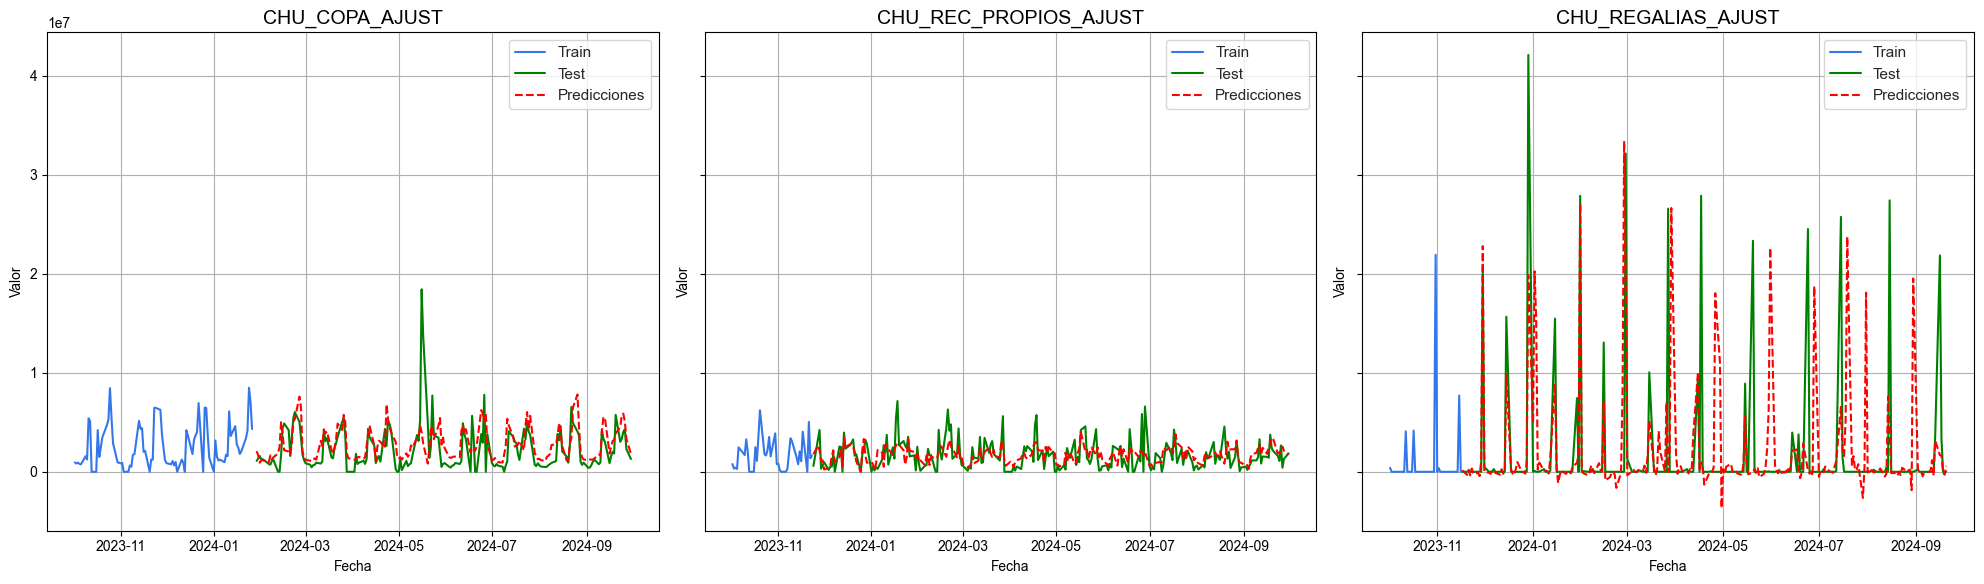

None

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=[pd.Series(dataframes_train[i][titulos[i]], index=dataframes_train[i].index) for i in range(len(dataframes_train))],
    dataframes_test=[pd.Series(dataframes_test[i][titulos[i]], index=dataframes_test[i].index) for i in range(len(dataframes_test))],
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2023-10-01'
))